In [1]:
import tensorflow as tf
from tensorflow import keras, data
from tensorflow.keras import layers, models, utils

import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import pandas as pd
from tqdm.notebook import tqdm
import os

2024-03-17 12:24:00.034143: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
IMG_SIZE=96
BATCH_SIZE=32
LATENT_DIM=256

In [3]:
dataset_path = 'faces/'

processed = []

# Iterate through images, crop, scale and store them in 'processed' array
for img in tqdm(os.listdir(dataset_path)):
    img = cv2.imread(dataset_path+img) #read image
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           #convert to RGB
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))           #resize
    img = tf.cast(img,'float32')/127.5 - 1              #normalize image to [-1,1]
    processed.append(img)                               #store in array

  0%|          | 0/29042 [00:00<?, ?it/s]

2024-03-17 12:24:01.980655: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-17 12:24:02.016514: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-17 12:24:02.016747: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [25]:
# Create a tensorflow dataset from given data, shuffle images and group them into batches
limit_training = 10000
test = 300

processed = np.array(processed)
np.random.shuffle(processed)

train_dataset = data.Dataset.from_tensor_slices(processed[:limit_training]) \
                .shuffle(1024, reshuffle_each_iteration=True) \
                .batch(BATCH_SIZE)

test_dataset = data.Dataset.from_tensor_slices(processed[limit_training:limit_training + test]).batch(BATCH_SIZE)
print(train_dataset,test_dataset)

2024-03-17 12:26:28.725921: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.


<_BatchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)> <_BatchDataset element_spec=TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None)>


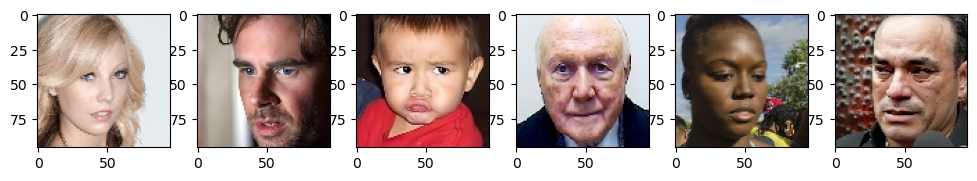

In [5]:
# Take a look at the dataset
imgs = next(iter(test_dataset))
fig = plt.figure(figsize=(12, 8))
rows = 6
for i in range(rows):
    fig.add_subplot(1,rows,i+1)
    plt.imshow((imgs[i]+1)*0.5) #scale images back to [0,1] in order to show them
plt.show()

In [6]:
from math import sqrt, prod

class EqualizedConv2D(layers.Layer):
    def __init__(self, c_in, c_out, k_size, stride=1, pad='VALID', bias=True):
        super().__init__()

        # define the weight and bias if to be used
        self.weight = self.add_weight(shape=(k_size, k_size, c_in, c_out), initializer='random_normal')

        self.use_bias = bias
        self.stride = stride
        if isinstance(pad, str):
            self.pad = pad
        else:
            self.pad = [[0, 0], [pad, pad], [pad, pad], [0, 0]]

        if self.use_bias:
            self.bias = self.add_weight(shape=(c_out,), initializer='zeros')

        fan_in = k_size * k_size * c_in  # value of fan_in
        self.scale = sqrt(2) / sqrt(fan_in)

    def call(self, inputs):
        """
        forward pass of the network
        :param x: input
        :return: y => output
        """

        y = tf.nn.conv2d(inputs,
                            self.weight * self.scale,  # scale the weight on runtime
                            strides=self.stride,
                            padding=self.pad)
        if self.use_bias:
            y = tf.nn.bias_add(y, self.bias)
        
        return y

In [7]:
class EqualizedDeConv2D(layers.Layer):
    def __init__(self, c_in, c_out, k_size, stride=1, pad='VALID', bias=True):
        """ constructor for the class """
        super().__init__()

        # define the weight and bias if to be used
        self.weight = self.add_weight(shape=(k_size, k_size, c_out, c_in), initializer='random_normal')

        self.use_bias = bias
        self.stride = stride
        if isinstance(pad, str):
            self.pad = pad
        else:
            self.pad = [[0, 0], [pad, pad], [pad, pad], [0, 0]]
        self.k_size = k_size
        self.c_in = c_in
        self.c_out = c_out

        if self.use_bias:
            self.bias = self.add_weight(shape=(c_out,), initializer='zeros')

        fan_in = c_in  # value of fan_in for deconv
        self.scale = sqrt(2) / sqrt(fan_in)

    def call(self, inputs):
        """
        forward pass of the layer
        :param x: input
        :return: y => output
        """

        if isinstance(self.pad, str):
            if self.pad == 'SAME':
                height = tf.shape(inputs)[1] * self.stride
                width = tf.shape(inputs)[2] * self.stride
            else:
                height = (tf.shape(inputs)[1] - 1) * self.stride + self.k_size
                width = (tf.shape(inputs)[2] - 1) * self.stride + self.k_size
        else:
            height = (tf.shape(inputs)[1] - 1) * self.stride + self.k_size - 2 * self.pad[1][0]
            width = (tf.shape(inputs)[2] - 1) * self.stride + self.k_size - 2 * self.pad[2][0]

        y = tf.nn.conv2d_transpose(inputs,
                                      self.weight * self.scale,  # scale the weight on runtime
                                      strides=self.stride,
                                      padding=self.pad,
                                      output_shape=[tf.shape(inputs)[0], height, width, self.c_out])
    
        if self.use_bias:
            y = tf.nn.bias_add(y, self.bias)
        
        return y

In [8]:
class PixelwiseNorm(layers.Layer):
    def __init__(self, alpha=1e-8):
        super().__init__()
        self.alpha = alpha

    def call(self, x):
        y = tf.math.reduce_mean(tf.square(x), axis=1, keepdims=True)
        y = tf.math.sqrt(y + self.alpha)  # [N1HW]
        y = x / y  # normalize the input x volume
        return y

In [9]:
class GeneratorInitialBlock(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        
        self.stack = keras.Sequential()
        self.stack.add(EqualizedDeConv2D(filters, filters, 3))
        self.stack.add(layers.LeakyReLU(alpha=0.2))
        self.stack.add(EqualizedConv2D(filters, filters, 3, pad=1))
        self.stack.add(layers.LeakyReLU(alpha=0.2))
        self.stack.add(PixelwiseNorm())

    def call(self, inputs):
        inputs = tf.expand_dims(tf.expand_dims(inputs, 1), 1)
        return self.stack(inputs)

In [10]:
class GeneratorGeneralBlock(layers.Layer):
    def __init__(self, in_filters, out_filters):
        super().__init__()

        self.stack = keras.Sequential()
        self.stack.add(layers.UpSampling2D())
        self.stack.add(EqualizedConv2D(in_filters, out_filters, 3, pad=1))
        self.stack.add(layers.LeakyReLU(alpha=0.2))
        self.stack.add(PixelwiseNorm())
        self.stack.add(EqualizedConv2D(out_filters, out_filters, 3, pad=1))
        self.stack.add(layers.LeakyReLU(alpha=0.2))
        self.stack.add(PixelwiseNorm())

    def call(self, inputs):
        return self.stack(inputs)

In [11]:
def to_rgb(in_filters):
    return EqualizedConv2D(in_filters, 3, 1)

In [12]:
import numpy as np

class Generator(models.Model):
    def __init__(self, latent_dim=512, depth=7):
        super().__init__()
        self.gen_layers = [GeneratorInitialBlock(latent_dim)]
        self.rgb_converters = [to_rgb(latent_dim)]

        for i in range(depth-1):
            if i <= 2:
                layer = GeneratorGeneralBlock(latent_dim, latent_dim)
                rgb = to_rgb(latent_dim)
            else:
                layer = GeneratorGeneralBlock(latent_dim // np.power(2, i-3), latent_dim // np.power(2, i-2))
                rgb = to_rgb(latent_dim // np.power(2, i-2))
            
            self.gen_layers.append(layer)
            self.rgb_converters.append(rgb)
    
    def call(self, inputs):
        outputs = []
        y = inputs
        for block, converter in zip(self.gen_layers, self.rgb_converters):
            y = block(y)
            outputs.append(converter(y))
        
        return outputs

In [13]:
class MinibatchStdDev(tf.keras.layers.Layer):
    """
    Minibatch standard deviation layer for the discriminator
    """

    def __init__(self, alpha=1e-8):
        """
        derived class constructor
        """
        super().__init__()
        self.alpha = alpha

    def call(self, x):
        """
        forward pass of the layer
        :param x: input activation volume
        :return: y => x appended with standard deviation constant map
        """
        batch_size = tf.shape(x)[0]
        width = tf.shape(x)[1]
        height = tf.shape(x)[2]

        # [B x H x W x C] Subtract mean over batch.
        y = x - tf.reduce_mean(x, axis=0, keepdims=True)

        # [1 x H x W x C]  Calc standard deviation over batch
        y = tf.math.sqrt(tf.reduce_mean(tf.square(y), axis=0, keepdims=True) + self.alpha)

        # [1]  Take average over feature_maps and pixels.
        y = tf.reduce_mean(y, keepdims=True)

        # [B x H x W x 1]  Replicate over group and pixels.
        y = tf.tile(y, [batch_size, height, width, 1])

        # [B x H x W x (C+1)]  Append as new feature_map.
        y = tf.concat([x, y], -1)

        # return the computed values:
        return y

In [14]:
class DiscriminatorGeneralBlock(layers.Layer):
    def __init__(self, in_filters, out_filters):
        super().__init__()
        
        self.stack = keras.Sequential()
        self.stack.add(EqualizedConv2D(in_filters, in_filters, 3, pad=1))
        self.stack.add(layers.LeakyReLU(alpha=0.2))
        self.stack.add(EqualizedConv2D(in_filters, out_filters, 3, pad=1))
        self.stack.add(layers.LeakyReLU(alpha=0.2))
        self.stack.add(layers.AveragePooling2D(2))

    def call(self, inputs):
        return self.stack(inputs)

In [15]:
class DiscriminatorFinalBlock(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        
        self.stack = keras.Sequential()

        self.stack.add(MinibatchStdDev())
        self.stack.add(EqualizedConv2D(filters + 1, filters, 3,
                                        pad=1))
        self.stack.add(layers.LeakyReLU(alpha=0.2))
        self.stack.add(EqualizedConv2D(filters, filters, 3))
        self.stack.add(layers.LeakyReLU(alpha=0.2))
        self.stack.add(EqualizedConv2D(filters, 1, 1))
        self.stack.add(layers.Flatten())

        
    def call(self, inputs):
        return self.stack(inputs)

In [16]:
def from_rgb(out_filters):
    return EqualizedConv2D(3, out_filters, 1)

In [17]:
class Discriminator(models.Model):
    def __init__(self, depth=7, feature_size=512):
        super().__init__()

        self.rgb_to_features = []
        self.final_converter = from_rgb(feature_size // 2)

        self.depth = depth

        self.disc_layers = []
        self.final_block = DiscriminatorFinalBlock(feature_size)

        for i in range(depth - 1):
            if i > 2:
                layer = DiscriminatorGeneralBlock(feature_size // np.power(2, i-2), feature_size // np.power(2, i-2))
                rgb = from_rgb(feature_size // np.power(2, i-1))
            else:
                layer = DiscriminatorGeneralBlock(feature_size, feature_size // 2)
                rgb = from_rgb(feature_size // 2)

            self.disc_layers.append(layer)
            self.rgb_to_features.append(rgb)

        self.rgb_to_features[depth - 2] = from_rgb(feature_size // np.power(2, i - 2))

    def call(self, inputs):
        y = self.rgb_to_features[self.depth - 2](inputs[self.depth - 1])
        y = self.disc_layers[self.depth - 2](y)

        for x, block, converter in zip(reversed(inputs[1:-1]), reversed(self.disc_layers[:-1]), reversed(self.rgb_to_features[:-1])):
            input_part = converter(x)
            y = tf.concat([input_part, y], axis=-1)
            y = block(y)
        
        input_part = self.final_converter(inputs[0])
        y = tf.concat([input_part, y], axis=-1)
        y = self.final_block(y)

        return keras.activations.sigmoid(y)

In [18]:
# from DiffAugment_tf import DiffAugment

# Custom GAN model
class GAN(keras.Model):
    def __init__(self, generator, discriminator, depth=6):
        '''Init model'''
        super().__init__()

        self.depth = depth

        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_optimizer, d_optimizer, g_loss_fn, d_loss_fn, latent_dim, **kwargs):
        '''Initialize metrics, optimizers and losses '''
        super().compile(**kwargs)
        
        self.g_loss_mean = keras.metrics.Mean(name="g_loss")
        self.d_loss_mean = keras.metrics.Mean(name="d_loss")
        
        self.real_acc = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_acc = keras.metrics.BinaryAccuracy(name="gen_acc")
        
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer

        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        
        # In this example, the same loss function will be provided for both sub-networks (BinaryCrossentropy)
        # However; there are improved GAN variations that use different losses (like WGAN)
        self.latent_dim = latent_dim
        
    @property
    def metrics(self):
        return [
            self.g_loss_mean,
            self.d_loss_mean,
            self.real_acc,
            self.generated_acc,
        ]
    
    
    def train_step(self,real_images):
        '''Perform one training step on a single batch of data.'''
        
        batch_size = tf.shape(real_images)[0]
        
        images = [real_images] + [tf.nn.avg_pool2d(real_images, np.power(2,i), np.power(2,i), 'VALID') for i in range(1,self.depth)]
        images = list(reversed(images))

        # 1. Train the discriminator
        
        # Generate some images
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim)) # Get noise for generator input

        # Normalize
        # random_noise = tf.math.l2_normalize(random_noise, axis=-1) * tf.math.sqrt(float(self.latent_dim))

        generated_images = self.generator(random_noise) # Generate images for discriminator training step
        
        real_labels = tf.ones((batch_size, 1)) * 0.9
        generated_labels = tf.zeros((batch_size, 1))

        # Train the network, update weights manually
        # GradientTape is used to record all calculations inside the network and calculate gradient during backprop
        with tf.GradientTape() as tape:            
            real_preds = self.discriminator(images)            # Predict classes for real images
            generated_preds = self.discriminator(generated_images)  # Predict classes for generated images

            d_loss = self.d_loss_fn(tf.concat([real_labels,generated_labels],axis=0), # true labels
                                  tf.concat([real_preds,generated_preds],axis=0))
          
        # Calculate discriminator gradients
        d_grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Apply weight changes
        self.d_optimizer.apply_gradients(zip(d_grads,self.discriminator.trainable_weights))
        
        random_noise = tf.random.normal(shape=(2*batch_size, self.latent_dim))

        misleading_labels = tf.ones((2*batch_size, 1))

        with tf.GradientTape() as tape:
            generated_images = self.generator(random_noise)
            fake_preds = self.discriminator(generated_images,training=False)
            g_loss = self.g_loss_fn(misleading_labels, fake_preds) 
      
        # Calculate generator gradients
        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)

        # Apply weight changes
        self.g_optimizer.apply_gradients(zip(g_grads,self.generator.trainable_weights))
        
        # Uupdate metrics
        self.g_loss_mean.update_state(g_loss)
        self.d_loss_mean.update_state(d_loss)
        self.real_acc.update_state(1.0, real_preds)
        self.generated_acc.update_state(0.0, generated_preds)
            
        return {'g_loss': g_loss, 'd_loss': d_loss,
               'real_acc': self.real_acc.result(), 'gen_acc': self.generated_acc.result()}

In [19]:
class ImageProgress(keras.callbacks.Callback):
    def __init__(self,latent_dim,images=6,every_epoch=10):
        '''Provide latent_dim, number of images to plot and frequency.'''
        self.random_vectors = tf.random.normal((images,latent_dim))
        self.every_epoch = every_epoch

    def on_epoch_end(self, epoch, logs=None):
        if (epoch) % self.every_epoch == 0:
            generated_images = self.model.generator(self.random_vectors,training=False)
        
            fig = plt.figure(figsize=(12, 8))
            for i, image in enumerate(generated_images[-3]):
                fig.add_subplot(1,len(self.random_vectors),i+1)
                image = (image.numpy()+1)*0.5 # Scale output from [-1,1] to [0,1]
                image = np.clip(image,0,1)
                plt.imshow(image)
            plt.show()

            fig = plt.figure(figsize=(12, 8))
            for i, image in enumerate(generated_images[-2]):
                fig.add_subplot(1,len(self.random_vectors),i+1)
                image = (image.numpy()+1)*0.5 # Scale output from [-1,1] to [0,1]
                image = np.clip(image,0,1)
                plt.imshow(image)
            plt.show()

            fig = plt.figure(figsize=(12, 8))
            for i, image in enumerate(generated_images[-1]):
                fig.add_subplot(1,len(self.random_vectors),i+1)
                image = (image.numpy()+1)*0.5 # Scale output from [-1,1] to [0,1]
                image = np.clip(image,0,1)
                plt.imshow(image)
            plt.show()

In [20]:
discriminator = Discriminator(depth=6, feature_size=LATENT_DIM)
d_optimizer=keras.optimizers.Adam(0.005, beta_1=0, beta_2=0.99)

generator = Generator(latent_dim=LATENT_DIM, depth=6)
g_optimizer=keras.optimizers.Adam(0.001, beta_1=0, beta_2=0.99)

/home/adrian/.miniforge3/envs/tf/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [21]:
gan = GAN(generator,discriminator)
gan.compile(g_optimizer,
            d_optimizer,
            keras.losses.BinaryCrossentropy(),
            keras.losses.BinaryCrossentropy(),
            LATENT_DIM)

In [26]:
history = gan.fit(train_dataset,
        epochs=500,
        callbacks=[ImageProgress(LATENT_DIM)]) 

Epoch 1/500


2024-03-17 12:26:37.457603: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1105920000 exceeds 10% of free system memory.
I0000 00:00:1710674815.085319   61244 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_30', 8 bytes spill stores, 8 bytes spill loads



 40/313 ━━━━━━━━━━━━━━━━━━━━ 1:26 318ms/step - d_loss: nan - g_loss: nan - gen_acc: nan - real_acc: nan

In [24]:
history = gan.history

In [26]:
g_loss, d_loss = history.history.values()

In [28]:
generator.save_weights("generator_msg.weights.h5")
discriminator.save_weights("discriminator_msg.weights.h5")

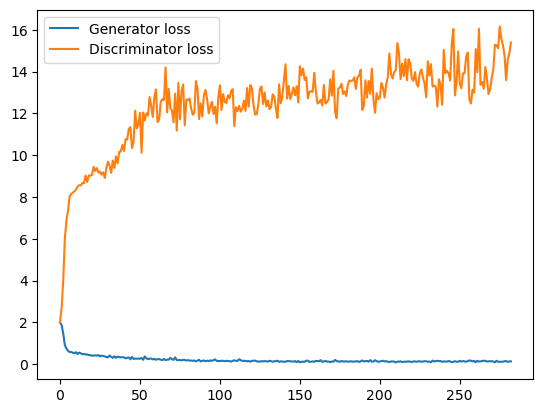

In [29]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.legend(['Generator loss','Discriminator loss'])
plt.show()

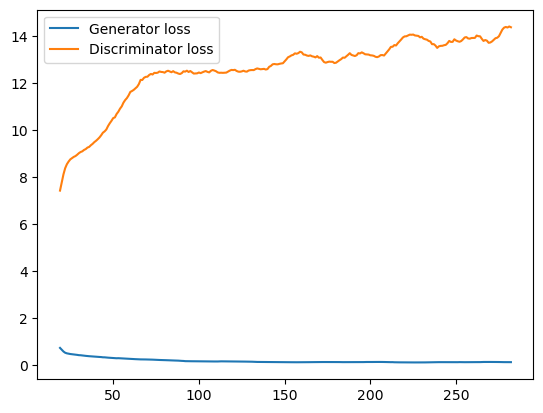

In [30]:
# Lets take a look at the smoothed plot (Simple Moving Average)

window_size = 20
# Convert array of integers to pandas series
d_sma_loss = pd.Series(d_loss)
g_sma_loss = pd.Series(g_loss)
  
# Get the window of series of observations of the specified window size
d_sma_loss = d_sma_loss.rolling(window_size).mean()
g_sma_loss = g_sma_loss.rolling(window_size).mean()

# Convert pandas series back to list
d_sma_loss = d_sma_loss.tolist()
g_sma_loss = g_sma_loss.tolist()

plt.plot(g_sma_loss)
plt.plot(d_sma_loss)
plt.legend(['Generator loss','Discriminator loss'])
plt.show()

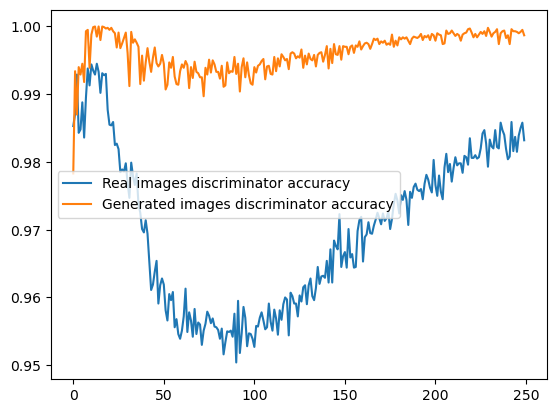

In [37]:
plt.plot(real_acc)
plt.plot(fake_acc)
plt.legend(['Real images discriminator accuracy','Generated images discriminator accuracy'])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

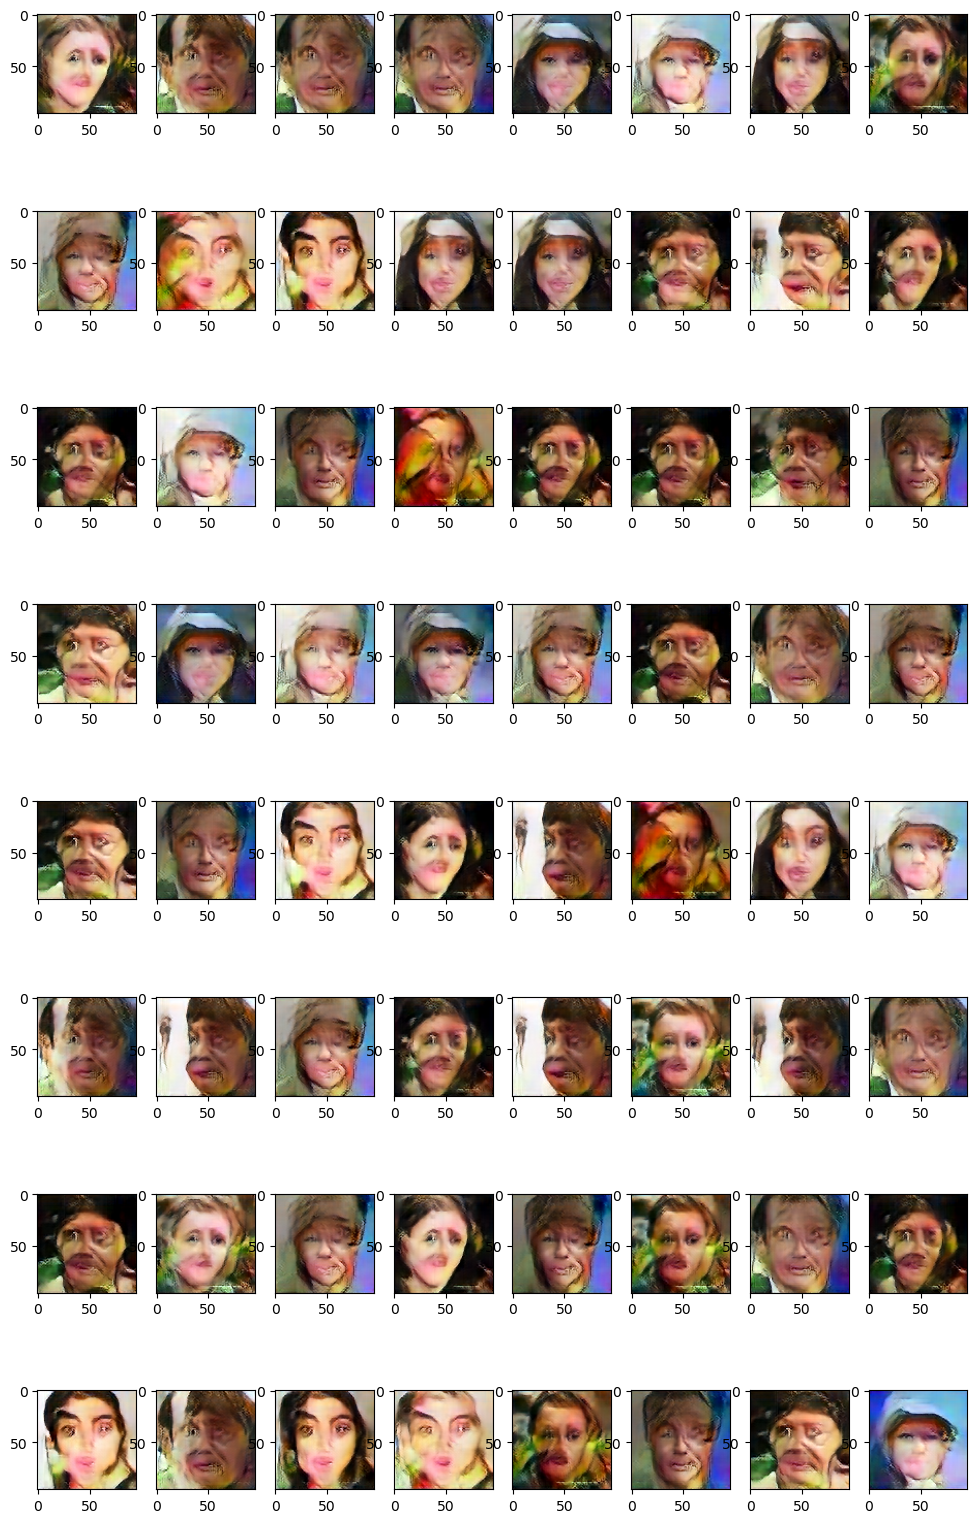

In [32]:
noise = tf.random.normal((64,LATENT_DIM))
generated = generator(noise,training=False)[-1]
fig = plt.figure(figsize=(12,20))
for i in range(8):
  for j in range(8):
    fig.add_subplot(8,8,i*8+j+1)
    plt.imshow((generated[i*8+j]+1)*0.5)
plt.show()

In [35]:
# 1. averaging two vectors
examples = 6
noise_1 = np.random.normal(size=(examples,LATENT_DIM))
noise_2 = np.random.normal(size=(examples,LATENT_DIM))
merged = (noise_1 + noise_2)/2 #mean

imgs_1 = generator(noise_1,training=False)[-1]
imgs_2 = generator(noise_2,training=False)[-1]
result = generator(merged,training=False)[-1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

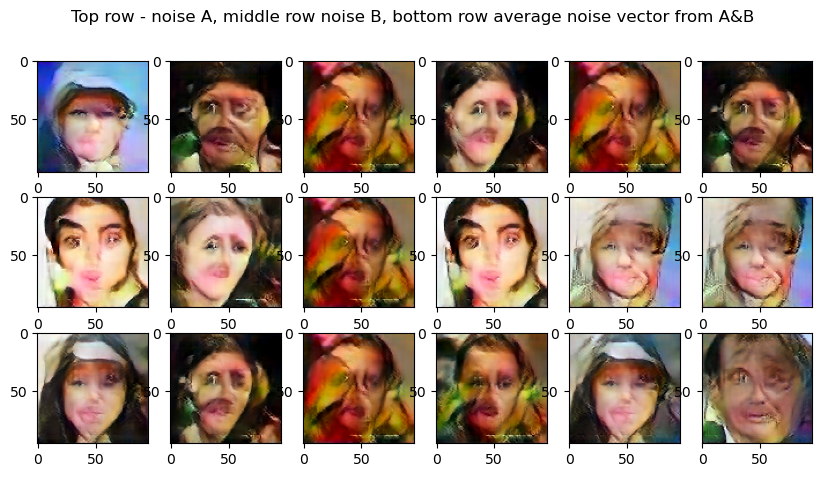

In [36]:
fig = plt.figure(figsize=(10,5))
for i, (a,b,c) in enumerate(zip(imgs_1,imgs_2,result)):
    fig.add_subplot(3,examples,1+i)
    plt.imshow((a+1)*0.5)
    fig.add_subplot(3,examples,examples+i+1)
    plt.imshow((b+1)*0.5)
    fig.add_subplot(3,examples,2*examples+i+1)
    plt.imshow((c+1)*0.5)

fig.suptitle("Top row - noise A, middle row noise B, bottom row average noise vector from A&B")
plt.show()

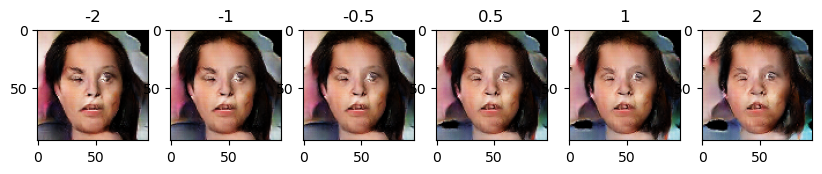

In [42]:
# Feature manipulation (changing single value in the original noise vector) 
noise = np.random.normal(size=(1,LATENT_DIM))
vals = [-2,-1,-0.5,0.5,1,2]                  # values to check
feature = 55                                 # from [0,LATENT_DIM-1]

def plot_feature_change(values,feature,noise):
    fig = plt.figure(figsize=(10,4))
    for index, shift in enumerate(values):
        noise_changed = np.copy(noise)
        noise_changed[0,feature] += shift
        image = generator(noise_changed)
        fig.add_subplot(1,len(vals),1+index)
        plt.imshow((image[0]+1)/2)
        plt.title(shift)
    plt.show()

plot_feature_change(vals,feature,noise)

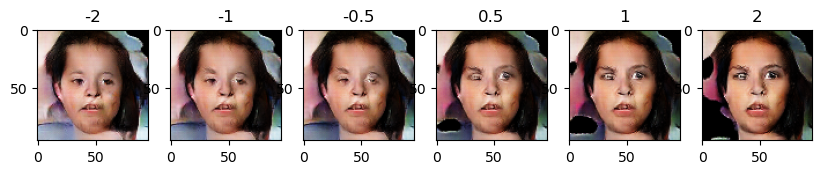

In [43]:
plot_feature_change(vals,11,noise)

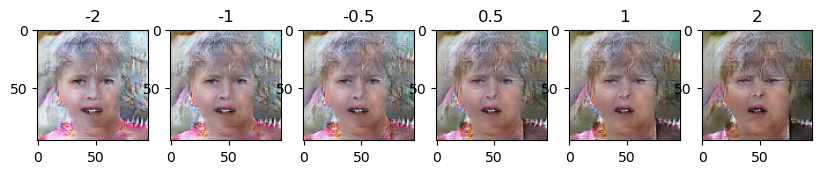

In [44]:
noise = np.random.normal(size=(1,LATENT_DIM)) #new noise
plot_feature_change(vals,11,noise)